# 1. 이해하기

## 1.1 전체 흐름

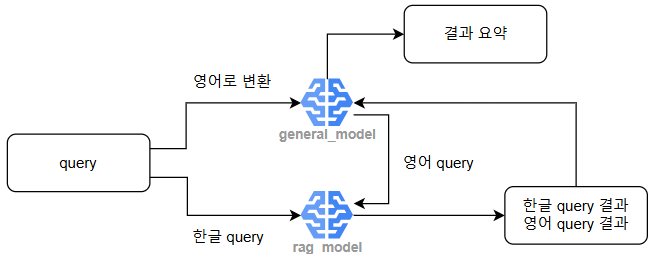

## 1.2 코드 흐름

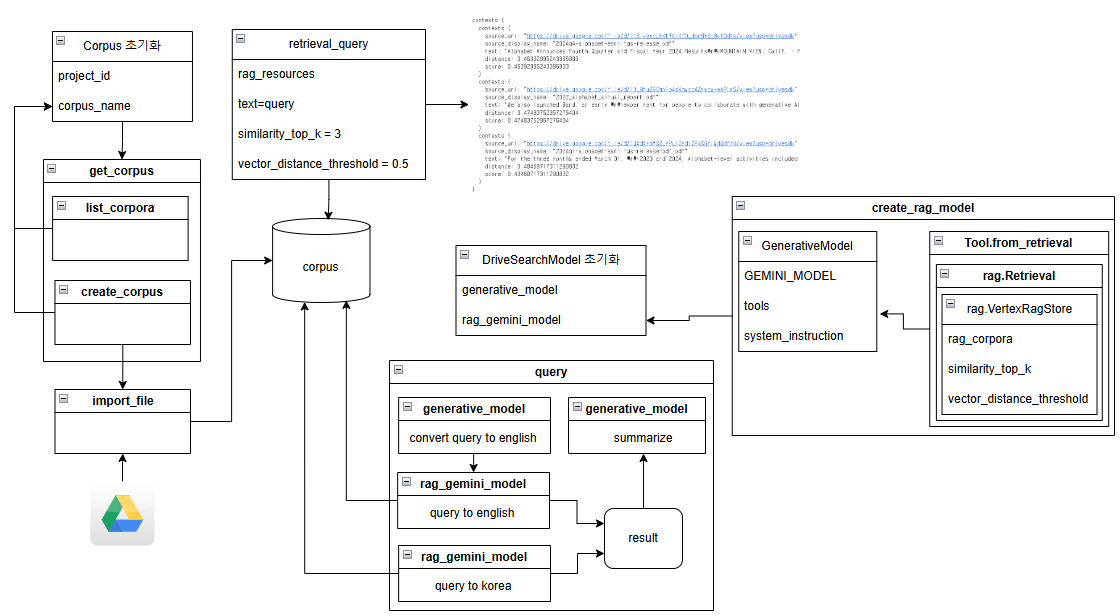

# 2. 환경설정

## 2.1 라이브러리 설치

In [ ]:
!pip install google-cloud-aiplatform

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## 2.2 환경변수 설정

In [1]:
import os

PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))
LOCATION = str(os.environ.get("GOOGLE_CLOUD_REGION", "us-central1"))
GEMINI_MODEL = "gemini-2.0-flash"

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"LOCATION: {LOCATION}")

PROJECT_ID: younkicho-364103
LOCATION: us-central1


##2.3 Gemini 초기화

In [3]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

# 3. RAG 구현

## 3.1 RAG Corpus 생성

In [4]:
from vertexai.preview import rag

EMBEDDING_MODEL = "publishers/google/models/text-embedding-004"
DISPLAY_NAME="gcs-rag-corpus"

In [56]:
class Corpus:
  def __init__(self, project_id) -> None:
    self.project_id = project_id
    self.corpus_name=""

  def crete_corpus(self, enbedding_model, display_name):
    embedding_model_config = rag.EmbeddingModelConfig(publisher_model=enbedding_model)

    return rag.create_corpus(
        display_name=display_name,
        embedding_model_config=embedding_model_config,
    )

  def get_corpus(self, enbedding_model, display_name):
    isCorpus=False

    for corpus in rag.list_corpora():
      if corpus.display_name == display_name:
        rag_corpus =  corpus
        isCorpus = True
        break

    if not isCorpus:
      rag_corpus = self.crete_corpus(enbedding_model, display_name)

    self.corpus_name = rag_corpus.name

  def import_file(self, input_gDrive):
    response = rag.import_files(
      corpus_name=self.corpus_name,
      paths=[input_gDrive],
      chunk_size=1024,
      chunk_overlap=100,
      max_embedding_requests_per_min=900
    )
    # result = await response.result()
    print(f"Imported {response.imported_rag_files_count} files.")

  def retrieval_query(self, query, top_k, threshold):
    return rag.retrieval_query(
      rag_resources=[
          rag.RagResource(
              rag_corpus=self.corpus_name,
          )
      ],
      text=query,
      similarity_top_k=top_k, # 3,  # Optional
      vector_distance_threshold=threshold #0.5,  # Optional
    )

In [57]:
_corpus = Corpus(PROJECT_ID)

In [58]:
_corpus.get_corpus(EMBEDDING_MODEL, DISPLAY_NAME)
_corpus.corpus_name

'projects/younkicho-364103/locations/us-central1/ragCorpora/6409748169655058432'

In [59]:
rag.list_corpora()

ListRagCorporaPager<rag_corpora {
  name: "projects/younkicho-364103/locations/us-central1/ragCorpora/6409748169655058432"
  display_name: "gcs-rag-corpus"
  rag_embedding_model_config {
    vertex_prediction_endpoint {
      endpoint: "projects/younkicho-364103/locations/us-central1/publishers/google/models/text-embedding-004"
    }
  }
  rag_vector_db_config {
    rag_managed_db {
    }
    rag_embedding_model_config {
      vertex_prediction_endpoint {
        endpoint: "projects/younkicho-364103/locations/us-central1/publishers/google/models/text-embedding-004"
      }
    }
  }
  create_time {
    seconds: 1739954421
    nanos: 611021000
  }
  update_time {
    seconds: 1739954421
    nanos: 611021000
  }
  corpus_status {
    state: ACTIVE
  }
  vector_db_config {
    rag_managed_db {
    }
    rag_embedding_model_config {
      vertex_prediction_endpoint {
        endpoint: "projects/younkicho-364103/locations/us-central1/publishers/google/models/text-embedding-004"
      }
    

### 3.2.2 결과 확인

In [60]:
query="""
2024년 구글의 총 수익은?
"""

response =_corpus.retrieval_query(query, 3, 0.5)
print(response)

contexts {
  contexts {
    source_uri: "https://drive.google.com/file/d/1nSivexcLtKt7kiKfD_dbr8V6_8vY0dts/view?usp=drivesdk"
    source_display_name: "2024q4-alphabet-earnings-release.pdf"
    text: "Alphabet Announces Fourth Quarter and Fiscal Year 2024 Results\r\nMOUNTAIN VIEW, Calif. – February 4, 2025 – Alphabet Inc. (NASDAQ: GOOG, GOOGL) today announced financial \r\nresults for the quarter and fiscal year ended December 31, 2024.\r\n• Consolidated Alphabet revenues in Q4 2024 increased 12% year over year to $96.5 billion reflecting robust \r\nmomentum across the business.\r\n• Google Services revenues increased 10% to $84.1 billion, reflecting the strong momentum across Google \r\nSearch & other and YouTube ads.\r\n• Google Cloud revenues increased 30% to $12.0 billion led by growth in Google Cloud Platform (GCP) across \r\ncore GCP products, AI Infrastructure, and Generative AI Solutions.\r\n• Total operating income increased 31% and operating margin expanded by 5% percentage p

In [61]:
query="""
google's total revenue in 2024
"""

response =_corpus.retrieval_query(query, 3, 0.5)
print(response)

contexts {
  contexts {
    source_uri: "https://drive.google.com/file/d/1nSivexcLtKt7kiKfD_dbr8V6_8vY0dts/view?usp=drivesdk"
    source_display_name: "2024q4-alphabet-earnings-release.pdf"
    text: "Alphabet Announces Fourth Quarter and Fiscal Year 2024 Results\r\nMOUNTAIN VIEW, Calif. – February 4, 2025 – Alphabet Inc. (NASDAQ: GOOG, GOOGL) today announced financial \r\nresults for the quarter and fiscal year ended December 31, 2024.\r\n• Consolidated Alphabet revenues in Q4 2024 increased 12% year over year to $96.5 billion reflecting robust \r\nmomentum across the business.\r\n• Google Services revenues increased 10% to $84.1 billion, reflecting the strong momentum across Google \r\nSearch & other and YouTube ads.\r\n• Google Cloud revenues increased 30% to $12.0 billion led by growth in Google Cloud Platform (GCP) across \r\ncore GCP products, AI Infrastructure, and Generative AI Solutions.\r\n• Total operating income increased 31% and operating margin expanded by 5% percentage p

# 4. 모델

## 4.1 모델 만들기

In [68]:
from vertexai.preview.generative_models import (
    GenerativeModel,
    Tool
)

In [69]:
class DriveSearchModel:
  def __init__(self, corpus_name, top_k, threashold, system_instruction) -> None:
    self.generative_model=GenerativeModel(
      GEMINI_MODEL,
      # system_instruction="입력된 prompt를 영어로 번역한다."
    )
    self.rag_gemini_model = self.create_rag_model(
        corpus_name, top_k, threashold, system_instruction
    )
  def create_rag_model(self, corpus_name, top_k, threashold, system_instruction):
    source = rag.VertexRagStore(
      rag_corpora=[corpus_name],
      similarity_top_k=top_k,
      vector_distance_threshold=threashold
    )

    retrieval = rag.Retrieval(source=source)
    rag_retrieval_tool = Tool.from_retrieval(retrieval)

    return GenerativeModel(
      GEMINI_MODEL,
      tools=[rag_retrieval_tool],
      system_instruction=system_instruction
    )
  def query(self, query):
    results=[]
    inner_query = f"""
    query : {query}
    위의 query를 영어로 번역해줘
    """
    response = self.generative_model.generate_content(inner_query)
    eng_query = response.text

    response = self.rag_gemini_model.generate_content(query)
    results.append(response.text)
    response = self.rag_gemini_model.generate_content(eng_query)
    results.append(response.text)

    query = f"""
    results : {results}
    위의 결과를 한글로 요약해줘
    """

    return self.generative_model.generate_content(query)

In [70]:
system_instruction="""
내용 추론시 참고한 문서 이름과 내용도 반드시 출력한다.

출력결과
  내용

참고 문서
  - doc1

참고 내용
  - doc1의 x페이지 y줄 인용
"""

In [71]:
_generativemodel = DriveSearchModel(
    _corpus.corpus_name,
    3,
    0.5,
    system_instruction
)

In [72]:
from IPython.display import display, Markdown
query="""
전년도 구글의 총 수익은?
"""

In [73]:
response = _generativemodel.query(query)
display(Markdown(response.text))

2024년 구글의 총 수익은 3,500억 1,800만 달러입니다. (참고 문서: 2024q4-alphabet-earnings-release.pdf)


In [74]:
query="""
전전년도 구글의 총 수익은?
"""
response = _generativemodel.query(query)
display(Markdown(response.text))

2023년 구글의 총 수익은 **3073억 9400만 달러**입니다. (출처: 2023년 4분기 Alphabet 실적 발표 PDF)


In [76]:
query="""
23년과 24년의 수익에 대해 비교 분석해줘
"""
response = _generativemodel.query(query)
display(Markdown(response.text))

제공된 문서들을 종합하면 다음과 같습니다:

*   **2023년 대비 2024년 Alphabet의 수익이 증가했습니다.** 2024년 총수익은 3,500억 1,800만 달러로 2023년의 3,073억 9,400만 달러에서 14% 증가했습니다.
*   **2024년 4분기 수익도 전년 동기 대비 증가했습니다.** 2024년 4분기 수익은 964억 6,900만 달러로 전년 동기 대비 12% 증가했습니다.
*   **영업이익과 순이익 또한 증가했습니다.** 2024년 영업이익은 1,123억 9,000만 달러로 2023년의 842억 9,300만 달러에서 증가했으며, 순이익은 2024년에 1,001억 1,800만 달러로 2023년의 737억 9,500만 달러에서 증가했습니다.
*   **2021년 Alphabet 연례 보고서는 제공되었지만, 2023년과 2024년 수익을 직접 비교하는 데는 사용되지 않았습니다.**


## 4.2 RAG 삭제

In [ ]:
corpus_list=rag.list_corpora()

for corpus in corpus_list:
  rag.delete_corpus(name=corpus.name)

NameError: name 'rag' is not defined

# 5. reference

* https://rudaks.tistory.com/entry/langchain-%ED%85%8D%EC%8A%A4%ED%8A%B8-%EB%B6%84%ED%95%A0-Text-Splitter#google_vignette
* https://mechiru.github.io/google-api-proto/google_api_proto/google/cloud/aiplatform/v1beta1/struct.ImportRagFilesConfig.html

* https://velog.io/@minbrok/Vertex-AI-RAG-Engine%EC%9D%84-%EC%82%AC%EC%9A%A9%ED%95%9C-Google-Drive-%ED%8C%8C%EC%9D%BC-RAG-%EA%B5%AC%ED%98%84
* https://cloud.google.com/vertex-ai/generative-ai/docs/samples/generativeaionvertexai-rag-import-files-async?hl=ko

* https://cloud.google.com/python/docs/reference/aiplatform/1.59.0/google.cloud.aiplatform_v1beta1.services.vertex_rag_data_service.pagers.ListRagCorporaPager
* https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/rag-api#corpus-management-examples-api